<h1>Capstone Project - The Battle of Neighborhood (Week 1)</h1>
<p> By: Charry Lam </p>

<h2>Problem Overview</h2>

<h2>Introduction:</h2>

<p>With the endless selection of food you get in the small town Lafayette, the decision to choose where to go is ever more difficult. Lafayette is home to the University of Louisina known as the Rajun Cajun and many international student study abroad. With that information I would like to know which restaurant have the best rating in the neighborhood?<p>

<h2> Business Challenge:</h2>

<p>Using Foursquare API, I will cluster similar restraunt together. Based on the output from foursquare, user can easily determine what type of restaurants are best to eat at based on feedback.</p>

<h2>Data Requirements: </h2>

<p>For this assignment, I will be utilizing the Foursquare API to pull the following location data on restaurants in Lafayette, Louisiana <p>


<ul>
    <li>Venue Name </li>
 <li>Venue ID</li>
 <li>Venue Location</li>
 <li>Venue Category</li>
 <li>Count of Likes</li>
    </ul>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import beautiful soup
from urllib.request import urlopen
from bs4 import BeautifulSoup


print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


<h2> Geographic Data for Lafayette </h2>

<p>Pulling data from foursquare </p>

In [120]:
address = 'Lafayette,louisiana'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lafayette are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Lafayette are 30.2240897, -92.0198427.


<h2>Foursquare API Usage <h2>

<p>Accessing Foursquare API <p>

In [121]:
CLIENT_ID = 'VRZK5XVDW0N32JIUOFGBNMA3OK51R03LJYZIBBI301YUWY31' # your Foursquare ID
CLIENT_SECRET = 'O1DD2VCCQF3FI4DSPRLNVWSRVI2BT11XD53SEOJX3WNGIR1R' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VRZK5XVDW0N32JIUOFGBNMA3OK51R03LJYZIBBI301YUWY31
CLIENT_SECRET:O1DD2VCCQF3FI4DSPRLNVWSRVI2BT11XD53SEOJX3WNGIR1R


<p> URL for all of the venues in Lafayette <p>

In [122]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=VRZK5XVDW0N32JIUOFGBNMA3OK51R03LJYZIBBI301YUWY31&client_secret=O1DD2VCCQF3FI4DSPRLNVWSRVI2BT11XD53SEOJX3WNGIR1R&v=20180605&ll=30.2240897,-92.0198427&radius=500&limit=100'

<p>Pulling the JSON for the URL of venues. <p>

In [123]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dddc39e7828ae001b4a8d60'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Lafayette',
  'headerFullLocation': 'Lafayette',
  'headerLocationGranularity': 'city',
  'totalResults': 44,
  'suggestedBounds': {'ne': {'lat': 30.228589704500006,
    'lng': -92.01464446646541},
   'sw': {'lat': 30.219589695499995, 'lng': -92.02504093353458}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b645082f964a5201aaa2ae3',
       'name': 'Pamplona Tapas Bar',
       'location': {'address': '631 Jefferson St',
        'lat': 30.22313255348899,
        'lng': -92.0188422717031,
        'labeledLatLngs': [{'label': 'disp

<p> Data into Dataframe for Table <p>

<p>Now we start pulling the data from Foursquare into a dataframe so we can manipulate and use it. </p>


In [124]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [125]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

#column formatting
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,Pamplona Tapas Bar,4b645082f964a5201aaa2ae3,Tapas Restaurant,30.223133,-92.018842
1,The French Press,4b4e1609f964a52008e126e3,Breakfast Spot,30.224067,-92.017341
2,Festival International De Louisiane,4bb3a9f035f0c9b6cfb5bc83,General Entertainment,30.224735,-92.018856
3,Pop's Poboys,554505d3498eb39976b193b7,Sandwich Place,30.221788,-92.018981
4,Carpe Diem! Gelato - Espresso Bar,4e0e6402fa76d62f4448b231,Dessert Shop,30.221663,-92.018885
5,Acadiana Center for the Arts,4b87094cf964a520ceac31e3,Theater,30.223930,-92.019100
6,Jefferson Street Pub,4b74d607f964a520a0f42de3,Bar,30.225770,-92.018780
7,The Wurst Biergarten,57476694498eca2fab9a2093,Beer Bar,30.224757,-92.018692
8,Tsunami,4b48e8dcf964a520f45c26e3,Sushi Restaurant,30.226454,-92.017849
9,Parc International,4bad1814f964a520f12c3be3,Music Venue,30.225448,-92.016770


In [126]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

nearby_venues['categories'].unique()

array(['Tapas Restaurant', 'Breakfast Spot', 'General Entertainment',
       'Sandwich Place', 'Dessert Shop', 'Theater', 'Bar', 'Beer Bar',
       'Sushi Restaurant', 'Music Venue', 'Other Great Outdoors',
       'Cajun / Creole Restaurant', 'Café', 'Science Museum',
       'Seafood Restaurant', 'Taco Place', 'Museum', 'Mexican Restaurant',
       'Sports Bar', 'Hotel', 'Hookah Bar', 'Performing Arts Venue',
       'Gay Bar', 'Pizza Place', 'Sculpture Garden', 'Clothing Store',
       'Bank', 'American Restaurant'], dtype=object)

In [127]:
# creating a list of categorie to remove from our dataframe because they are not restaurants
# I am sure there is a function that can be written to do this at scale but since it was a small list, I did it manually

removal_list = ['Gym / Fitness Center', 'Bakery', 'Park', "Women's Store", 'Sporting Goods Shop', 'Dog Run', 'Gaming Cafe',
               'Optical Shop', 'Yoga Studio', 'Pet Store', 'Shoe Repair', 'Jewelry Store', 'Record Shop', 'Juice Bar', 
               'Cosmetics Shop', 'Business Service', 'Salon / Barbershop', 'Liquor Store', 'Grocery Store', 'Stationery Store',
               'Pilates Studio', 'Dessert Shop', 'Bookstore', 'Concert Hall', 'Video Game Store', 'Pharmacy', 'Mobile Phone Shop',
               'Deli / Bodega']

nearby_venues2 = nearby_venues.copy()


#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2

,name,id,categories,lat,lng
0,Pamplona Tapas Bar,4b645082f964a5201aaa2ae3,Tapas Restaurant,30.223133,-92.018842
1,The French Press,4b4e1609f964a52008e126e3,Breakfast Spot,30.224067,-92.017341
2,Festival International De Louisiane,4bb3a9f035f0c9b6cfb5bc83,General Entertainment,30.224735,-92.018856
3,Pop's Poboys,554505d3498eb39976b193b7,Sandwich Place,30.221788,-92.018981
5,Acadiana Center for the Arts,4b87094cf964a520ceac31e3,Theater,30.223930,-92.019100
6,Jefferson Street Pub,4b74d607f964a520a0f42de3,Bar,30.225770,-92.018780
7,The Wurst Biergarten,57476694498eca2fab9a2093,Beer Bar,30.224757,-92.018692
8,Tsunami,4b48e8dcf964a520f45c26e3,Sushi Restaurant,30.226454,-92.017849
9,Parc International,4bad1814f964a520f12c3be3,Music Venue,30.225448,-92.016770
10,Antlers Downtown,4b4b60def964a520609926e3,Bar,30.224307,-92.018620


In [128]:
#let's get a list of venues

venue_id_list = nearby_venues2['id'].tolist()
venue_id_list

['4b645082f964a5201aaa2ae3',
 '4b4e1609f964a52008e126e3',
 '4bb3a9f035f0c9b6cfb5bc83',
 '554505d3498eb39976b193b7',
 '4b87094cf964a520ceac31e3',
 '4b74d607f964a520a0f42de3',
 '57476694498eca2fab9a2093',
 '4b48e8dcf964a520f45c26e3',
 '4bad1814f964a520f12c3be3',
 '4b4b60def964a520609926e3',
 '4c00628bad46c9b6f9708f66',
 '4b48c08ef964a520645526e3',
 '4b38b365f964a520874f25e3',
 '4c62227c4b5176b09a910017',
 '4e54e7608130102d7e60fdad',
 '4c3100ad452620a1f5fb1f0f',
 '4babf246f964a52002d83ae3',
 '4b48d768f964a520865926e3',
 '526407ae11d2566dc09f69da',
 '4b48e81af964a520cc5c26e3',
 '4af3fdc5f964a520c5ef21e3',
 '4bd0947ab221c9b6b7f9d3d0',
 '5179d13de4b0b5d316a91960',
 '4bdc9522c79cc928693987e9',
 '4b7458eaf964a520c8d62de3',
 '4b2d289cf964a520c9cf24e3',
 '4ba4137ff964a520e77e38e3',
 '4b48e5ebf964a520575c26e3',
 '4bb80a717421a5932876c140',
 '4dcfc7f8183899ddfaf48427',
 '4bcf96c577b29c7483738982',
 '4b4cf6fef964a520c2c526e3',
 '4b47cf3cf964a520b33f26e3',
 '4bd32a7fa8b3a593e43a695f',
 '4bd3509e0460

In [129]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[41, 86, 65, 21, 16, 18, 13, 34, 19, 9, 8, 46, 32, 3, 8, 14, 23, 7, 17, 31, 34, 8, 14, 7, 4, 45, 10, 33, 7, 4, 8, 13, 4, 5, 3, 1, 1, 0, 7, 2, 3, 4, 4]


In [130]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

43
43


<h2> Data Preparation </h2>

<p> <b> Part 1</b> <p>

In [131]:
#let's make a copy of our initial dataframe just in case anything goes wrong

to_venues = nearby_venues2.copy()
to_venues.head()

,name,id,categories,lat,lng
0,Pamplona Tapas Bar,4b645082f964a5201aaa2ae3,Tapas Restaurant,30.223133,-92.018842
1,The French Press,4b4e1609f964a52008e126e3,Breakfast Spot,30.224067,-92.017341
2,Festival International De Louisiane,4bb3a9f035f0c9b6cfb5bc83,General Entertainment,30.224735,-92.018856
3,Pop's Poboys,554505d3498eb39976b193b7,Sandwich Place,30.221788,-92.018981
5,Acadiana Center for the Arts,4b87094cf964a520ceac31e3,Theater,30.223930,-92.019100


In [132]:

# add in the list of likes

to_venues['total likes'] = like_list
to_venues.head()

,name,id,categories,lat,lng,total likes
0,Pamplona Tapas Bar,4b645082f964a5201aaa2ae3,Tapas Restaurant,30.223133,-92.018842,41
1,The French Press,4b4e1609f964a52008e126e3,Breakfast Spot,30.224067,-92.017341,86
2,Festival International De Louisiane,4bb3a9f035f0c9b6cfb5bc83,General Entertainment,30.224735,-92.018856,65
3,Pop's Poboys,554505d3498eb39976b193b7,Sandwich Place,30.221788,-92.018981,21
5,Acadiana Center for the Arts,4b87094cf964a520ceac31e3,Theater,30.223930,-92.019100,16


In [134]:
# now let's bin total likes

print(to_venues['total likes'].max())
print(to_venues['total likes'].min())
print(to_venues['total likes'].median())
print(to_venues['total likes'].mean())

86
0
9.0
17.023255813953487


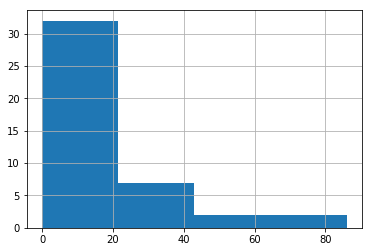

In [135]:
# let's visualize our total likes based on a histogram

import matplotlib.pyplot as plt
to_venues['total likes'].hist(bins=4)
plt.show()

In [136]:
# what are the bins we want to use?

print(np.percentile(to_venues['total likes'], 25))
print(np.percentile(to_venues['total likes'], 50))
print(np.percentile(to_venues['total likes'], 75))

4.0
9.0
22.0


In [137]:
# now we have our bin values so let's set them to the appropriate values
# less than 24, 24-45, 45-76, 76>
# poor, below avg, abv avg, great

poor = to_venues['total likes']<=24
below_avg = to_venues[(to_venues['total likes']>24) & (to_venues['total likes']<=45)]
abv_avg = to_venues[(to_venues['total likes']>45) & (to_venues['total likes']<=76)]
great = to_venues['total likes']>76

In [138]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=24:
        return 'poor'
    if s['total likes']<=45:
        return 'below avg'
    if s['total likes']<=76:
        return 'avg avg'
    if s['total likes']>76:
        return 'great'

to_venues['total likes_cat']=to_venues.apply(conditions, axis=1)

In [139]:
to_venues


,name,id,categories,lat,lng,total likes,total likes_cat
0,Pamplona Tapas Bar,4b645082f964a5201aaa2ae3,Tapas Restaurant,30.223133,-92.018842,41,below avg
1,The French Press,4b4e1609f964a52008e126e3,Breakfast Spot,30.224067,-92.017341,86,great
2,Festival International De Louisiane,4bb3a9f035f0c9b6cfb5bc83,General Entertainment,30.224735,-92.018856,65,avg avg
3,Pop's Poboys,554505d3498eb39976b193b7,Sandwich Place,30.221788,-92.018981,21,poor
5,Acadiana Center for the Arts,4b87094cf964a520ceac31e3,Theater,30.223930,-92.019100,16,poor
6,Jefferson Street Pub,4b74d607f964a520a0f42de3,Bar,30.225770,-92.018780,18,poor
7,The Wurst Biergarten,57476694498eca2fab9a2093,Beer Bar,30.224757,-92.018692,13,poor
8,Tsunami,4b48e8dcf964a520f45c26e3,Sushi Restaurant,30.226454,-92.017849,34,below avg
9,Parc International,4bad1814f964a520f12c3be3,Music Venue,30.225448,-92.016770,19,poor
10,Antlers Downtown,4b4b60def964a520609926e3,Bar,30.224307,-92.018620,9,poor


In [140]:
# let's star the process for re-categorizing the categories

to_venues['categories'].unique()

array(['Tapas Restaurant', 'Breakfast Spot', 'General Entertainment',
       'Sandwich Place', 'Theater', 'Bar', 'Beer Bar', 'Sushi Restaurant',
       'Music Venue', 'Other Great Outdoors', 'Cajun / Creole Restaurant',
       'Café', 'Science Museum', 'Seafood Restaurant', 'Taco Place',
       'Museum', 'Mexican Restaurant', 'Sports Bar', 'Hotel',
       'Hookah Bar', 'Performing Arts Venue', 'Gay Bar', 'Pizza Place',
       'Sculpture Garden', 'Clothing Store', 'Bank',
       'American Restaurant'], dtype=object)

In [141]:
# let's create our new categories and create a function to apply those to our existing data


bars = ['Pub', 'Cocktail Bar', 'Bar', 'Dive Bar', 'Sports Bar']
other = ['Bagel Shop', 'Tea Room', 'Donut Shop', 'Coffee Shop', 'Bubble Tea Shop', 'Sandwich Place', 'Boutique', 'Ice Cream Shop']
euro_asia_indian_food = ['Falafel Restaurant', 'Korean Restaurant','Sushi Restaurant', 'Indian Restaurant', 'Japanese Restaurant', 'Poke Place', 'Thai Restaurant', 'Vietnamese Restaurant']
mex_southam_food = ['Cuban Restaurant', 'Mexican Restaurant', 'South American Restaurant', 'Latin American Restaurant']
american_food = ['Burger Joint', 'Restaurant', 'American Restaurant']
italian_food = ['Italian Restaurant', 'Seafood Restaurant', 'Pizza Place']

def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in euro_asia_indian_food:
        return 'euro asia indian food'
    if s['categories'] in mex_southam_food:
        return 'mex southam food'
    if s['categories'] in american_food:
        return 'american food'
    if s['categories'] in italian_food:
        return 'italian food'

to_venues['categories_new']=to_venues.apply(conditions2, axis=1)

In [142]:
to_venues


,name,id,categories,lat,lng,total likes,total likes_cat,categories_new
0,Pamplona Tapas Bar,4b645082f964a5201aaa2ae3,Tapas Restaurant,30.223133,-92.018842,41,below avg,None
1,The French Press,4b4e1609f964a52008e126e3,Breakfast Spot,30.224067,-92.017341,86,great,None
2,Festival International De Louisiane,4bb3a9f035f0c9b6cfb5bc83,General Entertainment,30.224735,-92.018856,65,avg avg,None
3,Pop's Poboys,554505d3498eb39976b193b7,Sandwich Place,30.221788,-92.018981,21,poor,other
5,Acadiana Center for the Arts,4b87094cf964a520ceac31e3,Theater,30.223930,-92.019100,16,poor,None
6,Jefferson Street Pub,4b74d607f964a520a0f42de3,Bar,30.225770,-92.018780,18,poor,bars
7,The Wurst Biergarten,57476694498eca2fab9a2093,Beer Bar,30.224757,-92.018692,13,poor,None
8,Tsunami,4b48e8dcf964a520f45c26e3,Sushi Restaurant,30.226454,-92.017849,34,below avg,euro asia indian food
9,Parc International,4bad1814f964a520f12c3be3,Music Venue,30.225448,-92.016770,19,poor,None
10,Antlers Downtown,4b4b60def964a520609926e3,Bar,30.224307,-92.018620,9,poor,bars


<p> Incoming dummy variables <p>

In [143]:
# one hot encoding
to_onehot = pd.get_dummies(to_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Name'] = to_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

to_onehot.head()

,Name,american food,bars,euro asia indian food,italian food,mex southam food,other,avg avg,below avg,great,poor
0,Pamplona Tapas Bar,0,0,0,0,0,0,0,1,0,0
1,The French Press,0,0,0,0,0,0,0,0,1,0
2,Festival International De Louisiane,0,0,0,0,0,0,1,0,0,0
3,Pop's Poboys,0,0,0,0,0,1,0,0,0,1
5,Acadiana Center for the Arts,0,0,0,0,0,0,0,0,0,1


In [144]:
cluster_df = to_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 0, 1, 1, 2, 1, 3, 1, 2], dtype=int32)

In [145]:
to_venues['label'] = kmeans.labels_
to_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Pamplona Tapas Bar,4b645082f964a5201aaa2ae3,Tapas Restaurant,30.223133,-92.018842,41,below avg,None,3
1,The French Press,4b4e1609f964a52008e126e3,Breakfast Spot,30.224067,-92.017341,86,great,None,0
2,Festival International De Louisiane,4bb3a9f035f0c9b6cfb5bc83,General Entertainment,30.224735,-92.018856,65,avg avg,None,0
3,Pop's Poboys,554505d3498eb39976b193b7,Sandwich Place,30.221788,-92.018981,21,poor,other,1
5,Acadiana Center for the Arts,4b87094cf964a520ceac31e3,Theater,30.223930,-92.019100,16,poor,None,1


In [152]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_venues['lat'], to_venues['lng'], to_venues['name'], to_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<p> Cluster 1 </p>

In [92]:
to_venues.loc[to_venues['label']==0]


,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
1,The French Press,4b4e1609f964a52008e126e3,Breakfast Spot,30.224067,-92.017341,86,great,None,0
2,Festival International De Louisiane,4bb3a9f035f0c9b6cfb5bc83,General Entertainment,30.224735,-92.018856,65,avg avg,None,0
12,Johnson's Boucaniere,4b48c08ef964a520645526e3,Cajun / Creole Restaurant,30.221221,-92.022751,46,avg avg,None,0


<p>Cluster 2</p>

In [93]:
to_venues.loc[to_venues['label']==1]


,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
3,Pop's Poboys,554505d3498eb39976b193b7,Sandwich Place,30.221788,-92.018981,21,poor,other,1
5,Acadiana Center for the Arts,4b87094cf964a520ceac31e3,Theater,30.223930,-92.019100,16,poor,None,1
7,The Wurst Biergarten,57476694498eca2fab9a2093,Beer Bar,30.224757,-92.018692,13,poor,None,1
9,Parc International,4bad1814f964a520f12c3be3,Music Venue,30.225448,-92.016770,19,poor,None,1
11,Parc San Souci,4c00628bad46c9b6f9708f66,Other Great Outdoors,30.224517,-92.017597,8,poor,None,1
14,Subway Downtown,4c62227c4b5176b09a910017,Sandwich Place,30.225412,-92.018675,3,poor,other,1
15,Pat's Downtown,4e54e7608130102d7e60fdad,Cajun / Creole Restaurant,30.223111,-92.018385,8,poor,None,1
16,Lafayette Science Museum,4c3100ad452620a1f5fb1f0f,Science Museum,30.225641,-92.018215,14,poor,None,1
17,Don's Seafood & Steakhouse,4babf246f964a52002d83ae3,Seafood Restaurant,30.224244,-92.016631,23,poor,italian food,1
19,Black Café,526407ae11d2566dc09f69da,Café,30.228073,-92.018814,17,poor,None,1


<p>Cluster 3 </p>

In [94]:
to_venues.loc[to_venues['label']==2]


,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
6,Jefferson Street Pub,4b74d607f964a520a0f42de3,Bar,30.225770,-92.018780,18,poor,bars,2
10,Antlers Downtown,4b4b60def964a520609926e3,Bar,30.224307,-92.018620,9,poor,bars,2
18,NiteTown,4b48d768f964a520865926e3,Bar,30.225197,-92.018848,7,poor,bars,2
24,Legends Annex,4bdc9522c79cc928693987e9,Sports Bar,30.225961,-92.017247,7,poor,bars,2
29,Legends Downtown,4bb80a717421a5932876c140,Bar,30.226183,-92.017517,7,poor,bars,2
32,Marley's,4b4cf6fef964a520c2c526e3,Bar,30.226199,-92.017435,13,poor,bars,2
33,The Office,4b47cf3cf964a520b33f26e3,Bar,30.226747,-92.016773,4,poor,bars,2
39,Arcadian Bar and Grill,52731805498ed32cc0e1f5cb,Bar,30.226878,-92.016997,7,poor,bars,2


<p>Cluster 4 <p>

In [97]:
to_venues.loc[to_venues['label']==3]


,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Pamplona Tapas Bar,4b645082f964a5201aaa2ae3,Tapas Restaurant,30.223133,-92.018842,41,below avg,None,3
8,Tsunami,4b48e8dcf964a520f45c26e3,Sushi Restaurant,30.226454,-92.017849,34,below avg,euro asia indian food,3
13,Dwyer's Cafe,4b38b365f964a520874f25e3,Café,30.226655,-92.017300,32,below avg,None,3
20,Taco Sisters,4b48e81af964a520cc5c26e3,Taco Place,30.223280,-92.014986,31,below avg,None,3
21,The Green Room,4af3fdc5f964a520c5ef21e3,Bar,30.226871,-92.016866,34,below avg,bars,3
26,Artmosphere,4b2d289cf964a520c9cf24e3,Hookah Bar,30.220519,-92.017200,45,below avg,None,3
28,Agave Mexican Cantina & Grill,4b48e5ebf964a520575c26e3,Mexican Restaurant,30.224000,-92.017570,33,below avg,mex southam food,3


<h3>Results / Conclusion</h3>
<p>
With the different restaurants in the area in Lafayette, based on the reviews the best place to eat would be "The French Press". There are many selections of venues around the area also, with the feedback Festival International De Louisiane" and "Johnson's Boucaniere" would also be a nice option to check out. All of the analysis is based on feedback from the number of feedback which would require higher feedback to recieve a higher ranking.</p>